In [28]:
# --------------------------------------------------------------
#  long_range_ising_rg.py
# --------------------------------------------------------------
import numpy as np
from numba import njit
from itertools import product

# ----------  spin configurations (global, read-only) ----------
all_spins = list(product([-1, 1], repeat=3))
plus_spins  = np.array([s for s in all_spins if sum(s) >= 1], dtype=np.float64)
minus_spins = np.array([s for s in all_spins if sum(s) <= -1], dtype=np.float64)

# ----------  intracell energy (J2 = nearest, J4 = next-nearest) ----------
@njit
def _intracell_energy(spins, J2, J4):
    n = spins.shape[0]
    E = np.zeros(n, dtype=np.float64)
    for i in range(n):
        s0, s1, s2 = spins[i, 0], spins[i, 1], spins[i, 2]
        E[i] = J2*s0*s1 + J2*s1*s2 + J4*s0*s2
    return E

# ----------  log-R for a pair of cells (H included) ----------
@njit
def _logR(spinsL, EL, spinsR, ER, dists, Jarr, H):
    nL, nR = spinsL.shape[0], spinsR.shape[0]
    nd = dists.shape[0]
    tot = np.zeros(nL*nR, dtype=np.float64)
    idx = 0
    for i in range(nL):
        magL = spinsL[i,0] + spinsL[i,1] + spinsL[i,2]
        for j in range(nR):
            magR = spinsR[j,0] + spinsR[j,1] + spinsR[j,2]
            Eint = 0.0
            for k in range(nd):
                iL, iR, d = dists[k]
                Eint += Jarr[d] * spinsL[i,iL] * spinsR[j,iR]
            tot[idx] = EL[i] + ER[j] + Eint + H*(magL + magR)
            idx += 1
    if tot.size == 0: return -np.inf
    mx = np.max(tot)
    s = np.sum(np.exp(tot - mx))
    return np.log(s) + mx if s > 0.0 else -np.inf

# ----------  H' for the nearest-neighbour cell pair (r'=1) ----------
@njit
def _Hprime(Jarr, H):
    J2, J4 = Jarr[2], Jarr[4]
    ELp = _intracell_energy(plus_spins,  J2, J4)
    ELm = _intracell_energy(minus_spins, J2, J4)

    # geometry of the two nearest-neighbour cells
    start = 4
    left  = np.array([1,3,5], dtype=np.int64)
    right = np.array([start, start+2, start+4], dtype=np.int64)
    dists = np.empty((9,3), dtype=np.int64)
    k = 0
    for iL in range(3):
        for iR in range(3):
            dists[k] = (iL, iR, abs(right[iR]-left[iL]))
            k += 1

    log_pp = _logR(plus_spins,  ELp, plus_spins,  ELp, dists, Jarr, H)
    log_mm = _logR(minus_spins, ELm, minus_spins, ELm, dists, Jarr, H)
    if np.isinf(log_pp) or np.isinf(log_mm): return np.nan
    return 0.25*(log_pp - log_mm)

# ----------  dH'/dH at H = 0 (finite difference) ----------
@njit
def dHdH(Jarr, eps=1e-8):
    H0   = _Hprime(Jarr, 0.0)
    Heps = _Hprime(Jarr, eps)
    if np.isnan(H0) or np.isnan(Heps): return np.nan
    return (Heps - H0)/eps

# ----------  renormalised coupling J'(r') (no Python callable) ----------
@njit
def _Jprime(start, Jarr):
    J2 = Jarr[2]
    J4 = Jarr[4]
    left  = np.array([1,3,5], dtype=np.int64)
    right = np.array([start, start+2, start+4], dtype=np.int64)
    dists = np.empty((9,3), dtype=np.int64)
    k = 0
    for iL in range(3):
        for iR in range(3):
            dists[k] = (iL, iR, abs(right[iR]-left[iL]))
            k += 1

    ELp = _intracell_energy(plus_spins,  J2, J4)
    ELm = _intracell_energy(minus_spins, J2, J4)

    log_pp = _logR(plus_spins,  ELp, plus_spins,  ELp, dists, Jarr, 0.0)
    log_pm = _logR(plus_spins,  ELp, minus_spins, ELm, dists, Jarr, 0.0)
    if np.isinf(log_pp) or np.isinf(log_pm): return np.inf
    return 0.5*(log_pp - log_pm)

# ----------  find critical Jc(a) (once) ----------
def find_Jc(a, max_k=1200, tol=1e-8, Jlow=0.1, Jhigh=12.0):
    if not (0 < a < 2): raise ValueError("a must be in (0,2)")

    md = 3*max_k + 10
    rs = np.arange(1, max_k+1, dtype=np.int64)

    def grows(J0):
        Jarr = np.zeros(md+1, dtype=np.float64)
        Jarr[1:] = J0 * np.power(np.arange(1, md+1, dtype=np.float64), -a)
        cur = Jarr.copy()
        for _ in range(8):                     # enough steps to see trend
            Jp = np.empty(max_k, dtype=np.float64)
            for ri in range(max_k):
                Jp[ri] = _Jprime(3*rs[ri]+1, cur)
            cur = np.zeros(md+1, dtype=np.float64)
            cur[1:max_k+1] = Jp
            if max_k > 1 and abs(Jp[1]) > 1e7: return True
            if max_k > 1 and abs(Jp[1]) < 1e-7: return False
        return abs(Jp[1]) > abs(Jarr[2])

    while Jhigh - Jlow > tol:
        Jmid = (Jlow + Jhigh)*0.5
        if grows(Jmid): Jhigh = Jmid
        else:           Jlow  = Jmid
    return (Jlow + Jhigh)*0.5

# ----------  magnetisation by back-propagation ----------
def magnetisation(J0, a, Jc, max_k=800, max_steps=30, eps=1e-8):
    """
    J0 – starting coupling (=1/T)
    a  – power-law exponent
    Jc – critical coupling for this a (from find_Jc)
    """
    b, d = 3.0, 1.0
    M_sink = 1.0 if J0 > Jc else 0.0
    if M_sink == 0.0: return 0.0

    md = 3*max_k + 10
    Jarr = np.zeros(md+1, dtype=np.float64)
    Jarr[1:] = J0 * np.power(np.arange(1, md+1, dtype=np.float64), -a)

    rs = np.arange(1, max_k+1, dtype=np.int64)
    cur = Jarr.copy()
    prodR = 1.0

    for step in range(max_steps):
        # ---- renormalise couplings ----
        Jp = np.empty(max_k, dtype=np.float64)
        for ri in range(max_k):
            Jp[ri] = _Jprime(3*rs[ri]+1, cur)

        # ---- dH'/dH at this level ----
        dh = dHdH(cur, eps)
        if np.isnan(dh) or dh <= 0.0: break
        prodR *= dh

        # ---- next lattice ----
        cur = np.zeros(md+1, dtype=np.float64)
        cur[1:max_k+1] = Jp

    scale = (b**(-d))**(step+1)
    M0 = scale * prodR * M_sink
    return M0#np.clip(M0, 0.0, 1.0)

In [4]:
# Cell 1 – critical coupling
a = 1.3
Jc = find_Jc(a, max_k=1200, tol=1e-9)
print(f"a = {a:.3f}  →  Jc = {Jc:.10f}  (Tc = {1/Jc:.6f})")

a = 1.300  →  Jc = 0.7815872040  (Tc = 1.279448)


In [5]:
# Cell 2 – dH'/dH at the critical point
max_d = 3*1200 + 10
Jarr_crit = np.zeros(max_d+1, dtype=np.float64)
Jarr_crit[1:] = Jc * np.power(np.arange(1, max_d+1, dtype=np.float64), -a)

dh = dHdH(Jarr_crit, eps=1e-9)
yH = np.log(dh)/np.log(3.0)
print(f"dH'/dH = {dh:.6f}   →   y_H = {yH:.4f}")

dH'/dH = 2.552965   →   y_H = 0.8531


In [6]:
# Cell 3 – magnetisation at a chosen temperature
J0 = 1.8                       # = 1/T
M  = magnetisation(J0, a, Jc, max_k=800, max_steps=35)
print(f"J0 = {J0:.3f} (T = {1/J0:.3f})  →  M0 = {M:.6f}")

J0 = 1.800 (T = 0.556)  →  M0 = 0.981420


In [7]:
# Cell 4 – quick M(T) curve (no plot)
Tvals = np.logspace(np.log10(0.3/Jc), np.log10(3/Jc), 40)
Mvals = [magnetisation(1/T, a, Jc, max_k=700) for T in Tvals]
# Mvals now holds the spontaneous magnetisation for each T

Computing dH'/dH at criticality for a in [0.8, 1.95]...
a = 0.800 → Jc = 0.153031, dH'/dH = 1.756949, y_H = 0.5130
a = 0.840 → Jc = 0.182910, dH'/dH = 1.807712, y_H = 0.5389
a = 0.879 → Jc = 0.215738, dH'/dH = 1.863518, y_H = 0.5666
a = 0.919 → Jc = 0.251622, dH'/dH = 1.924123, y_H = 0.5957
a = 0.959 → Jc = 0.290672, dH'/dH = 1.988998, y_H = 0.6259
a = 0.998 → Jc = 0.333010, dH'/dH = 2.057305, y_H = 0.6566
a = 1.038 → Jc = 0.378773, dH'/dH = 2.127908, y_H = 0.6874
a = 1.078 → Jc = 0.428119, dH'/dH = 2.199432, y_H = 0.7174
a = 1.117 → Jc = 0.481231, dH'/dH = 2.270374, y_H = 0.7463
a = 1.157 → Jc = 0.538320, dH'/dH = 2.339241, y_H = 0.7735
a = 1.197 → Jc = 0.599630, dH'/dH = 2.404705, y_H = 0.7987
a = 1.236 → Jc = 0.665442, dH'/dH = 2.465722, y_H = 0.8215
a = 1.276 → Jc = 0.736077, dH'/dH = 2.521606, y_H = 0.8419
a = 1.316 → Jc = 0.811901, dH'/dH = 2.572053, y_H = 0.8599
a = 1.355 → Jc = 0.893333, dH'/dH = 2.617090, y_H = 0.8757
a = 1.395 → Jc = 0.980852, dH'/dH = 2.657015, y_H = 0.8895


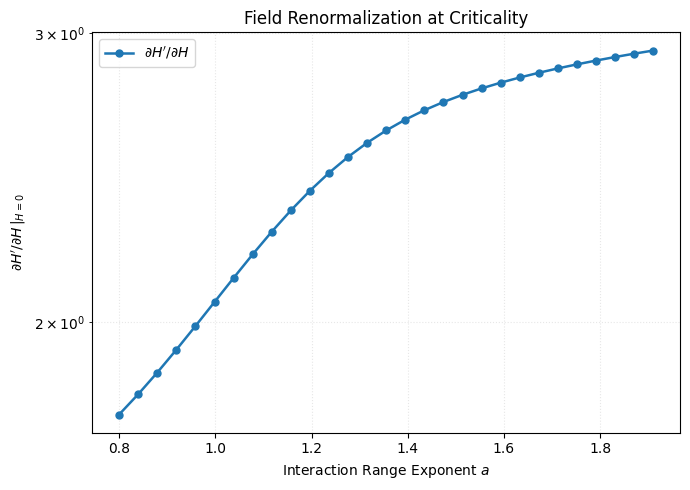

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# --- PARAMETERS ---
a_vals = np.linspace(0.8, 1.95, 30)   # avoid a=2.0 (first-order)
max_k = 1200
tol = 1e-9
eps = 1e-9

dh_vals = []
Jc_vals = []

print("Computing dH'/dH at criticality for a in [0.8, 1.95]...")
for a in a_vals:
    try:
        Jc = find_Jc(a, max_k=max_k, tol=tol)
        max_d = 3*max_k + 10
        Jarr = np.zeros(max_d+1, dtype=np.float64)
        Jarr[1:] = Jc * np.power(np.arange(1, max_d+1, dtype=np.float64), -a)
        
        dh = dHdH(Jarr, eps=eps)
        yH = np.log(dh)/np.log(3.0) if dh > 0 else np.nan
        
        dh_vals.append(dh)
        Jc_vals.append(Jc)
        print(f"a = {a:.3f} → Jc = {Jc:.6f}, dH'/dH = {dh:.6f}, y_H = {yH:.4f}")
    except:
        dh_vals.append(np.nan)
        Jc_vals.append(np.nan)

# --- PLOT ---
plt.figure(figsize=(7, 5))
valid = ~np.isnan(dh_vals)
plt.semilogy(np.array(a_vals)[valid], np.array(dh_vals)[valid], 
             'o-', color='tab:blue', markersize=5, linewidth=1.8, label="$\\partial H'/\\partial H$")

plt.xlabel('Interaction Range Exponent $a$')
plt.ylabel("$\\partial H'/\\partial H \\,|_{H=0}$")
plt.title('Field Renormalization at Criticality')
plt.grid(True, alpha=0.3, which='both', ls=':')
plt.legend()
plt.tight_layout()
plt.show()

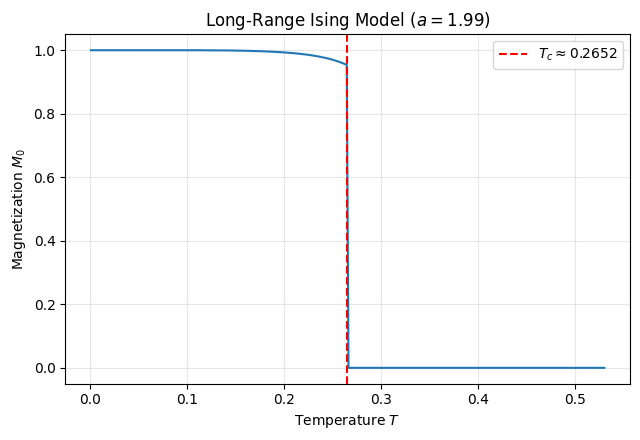

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# --- INPUT ---
a = 1.99
Jc = find_Jc(a, max_k=1200, tol=1e-9)
Tc = 1.0 / Jc

# Temperature range: from 0.3*Tc to 3*Tc (log scale)
Tvals = np.linspace(0.001, 2*Tc, 300)

# Compute magnetisation
Mvals = [magnetisation(1.0/T, a, Jc, max_k=1000, max_steps=5) for T in Tvals]

# --- PLOT ---
plt.figure(figsize=(6.5, 4.5))
plt.plot(Tvals, Mvals, '-', color='tab:blue', markersize=4, linewidth=1.5)
plt.axvline(Tc, color='red', linestyle='--', linewidth=1.5, label=f'$T_c \\approx {Tc:.4f}$')
plt.xlabel('Temperature $T$')
plt.ylabel('Magnetization $M_0$')
plt.title(f'Long-Range Ising Model ($a = {a}$)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(f'../figures/magnetization_a{a}.png')
plt.show()

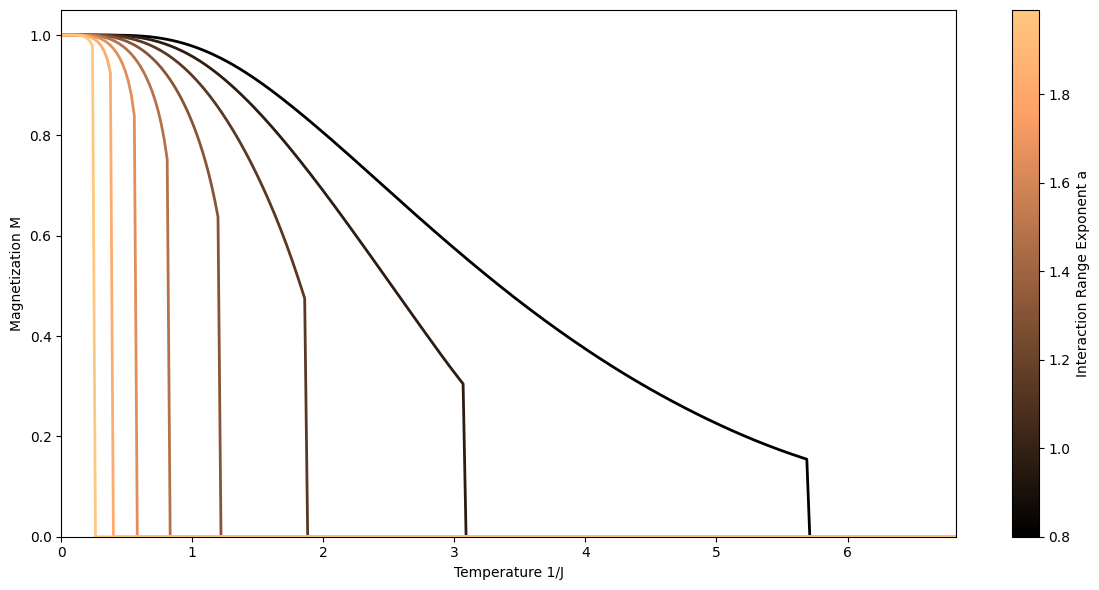

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# ------------------------------------------------------------------
# 1. Choose the exponents a and a common temperature grid
# ------------------------------------------------------------------
a_values = np.linspace(0.8, 1.99, 8)
max_k    = 3**6
tol      = 1e-6

# temperature range (linear) that covers all Tc
Tc_max = 1.0 / find_Jc(a_values[ 0], max_k=max_k, tol=tol)   # largest Tc (smallest a)
T_min, T_max = 0.01, 1.2 * Tc_max
Tvals = np.linspace(T_min, T_max, 300)                     # 300 points, linear

# ------------------------------------------------------------------
# 2. Compute Jc for every a (once) and then M(T) for each a
# ------------------------------------------------------------------
M_matrix = np.zeros((len(Tvals), len(a_values)))   # rows = T, columns = a

for i, a in enumerate(a_values):
    Jc = find_Jc(a, max_k=max_k, tol=tol)          # critical coupling
    # magnetisation for every temperature in the grid
    M_matrix[:, i] = [
        magnetisation(1.0/T, a, Jc, max_k=max_k, max_steps=6) if T > 0 else 0.0
        for T in Tvals
    ]

# ------------------------------------------------------------------
# 3. Plot with a colormap
# ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(12, 6))
cmap = cm.copper
norm = plt.Normalize(a_values.min(), a_values.max())

for i, a_i in enumerate(a_values):
    ax.plot(Tvals, M_matrix[:, i], marker='',
            linewidth=2, color=cmap(norm(a_i)))

# colour-bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
fig.colorbar(sm, ax=ax, label='Interaction Range Exponent a')

ax.set_xlabel('Temperature 1/J')
ax.set_ylabel('Magnetization M')
ax.set_ylim(0, 1.05)
ax.set_xlim(0, T_max)
ax.grid(False)
plt.tight_layout()
plt.savefig('../figures/magnetization_all_a.png')
plt.show()